CAM定义

CAM全称Class Activation Mapping，既类别激活映射图，也被称为类别热力图、显著性图等。是一张和原始图片等同大小图，该图片上每个位置的像素取值范围从0到1，一般用0到255的灰度图表示。可以理解为对预测输出的贡献分布，分数越高的地方表示原始图片对应区域对网络的响应越高、贡献越大。

为了更直观表达，一般将灰度图转化为彩色图。例如可以使用Opencv 函数转换：

In [ ]:
img_color = cv2.applyColorMap(img_gray, cv2.COLORMAP_JET) # 将灰度图转化为伪色彩图，                                                                    
# COLORMAP_JET 为输出的颜色模式

可视化的时候，可以利用热力图和原图叠加的形式呈现。如下图，颜色越深红的地方表示值越大。可以认为，网络预测“狗”这个类别时，红色高亮区域是其主要判断依据。

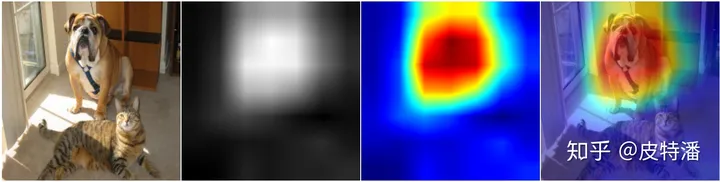

CAM主要有以下作用:

1.有助于理解和分析神经网络的工作原理及决策过程，进而去更好地选择或设计网络。例如对于分类网络，如果参考CAM相当于除了分类accuracy以外，对网络又提出了更高的要求：不但要求预测准确率高，还需要网络提取到我们需要的特征。下图可以看出，不同网络对相同的数据的CAM是有较为明显的差异。当然即便是同一个网络，不同训练过程也会导致CAM有很大的差异。

2.利用可视化的信息引导网络更好的学习，例如可以利用CAM信息通过"擦除"或""裁剪""的方式对数据进行增强；

3.利用CAM作为原始的种子，进行弱监督语义分割或弱监督定位。既然CAM能够cover到目标物体，所以可以仅利用分类标注来完成语义分割或目标检测任务，极大程度上降低了标注的工作量，但这对CAM的要求更高。一般情况下，分类网络只会提取到最具有判别性的特征。所以也有很多做法来提高分类网络的CAM精准度。

CAM原理

卷积神经网络的卷积操作可以看做是滤波器对图片进行特征提取，通过滑动窗口的方式实现，因此特征层和输入图片存在空间上的对应关系。特征图中，某一位置的值越大，表明特征越有效，对网络预测结果越重要。一个深层的卷积神经网络，通过层层卷积操作，提取空间和语义信息。一般存在其他更难理解的层，例如分类的全连接层、softmax层等，很难以利用可视化的方式展示出来。所以，CAM的提取一般发生在卷积层，尤其是最后一层卷积。通常每一层的特征图还会有很多层，一般称为channel（通道），例如Resnet18最后一层特征图有512个通道。这512个通道可以认为提取到不同的特征，该特征具有高度抽象性，且每个通道对最后的结果贡献不同，因此单独可视化每个通道获取热图也让人很难理解。所以一般CAM的获取是根据每个通道不同的贡献大小去融合获取一张CAM。

所以，总结CAM获取的步骤如下：

step1：提取需要可视化的特征层，例如尺寸为7 * 7 * 512的张量；

step2：获取该张量的每个channel的权重，即长度为512的向量；

step3：通过线性融合的方式，将该张量在channel维度上加权求和，获取尺寸为7*7的map；

step4：对该map进行归一化，并通过插值的方式resize到原图尺寸；

CAM有两种不同的阵营gradient-based和gradient-free。 做法不同，其本质类似: 提取目标特征层，并进行加权融合获取激活图(CAM)。 主要的区别在于上述step2叙述的特征层之间融合权重的选择上。gradient-based利用梯度获取权重，gradient-free 则不需要梯度信息。

gradient-based的方法：GAP  (Learning Deep Features for Discriminative Localizatiion)

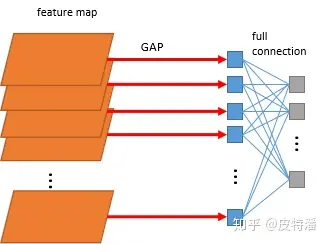

首先介绍一下GAP(Global average pooling，全局平均池化 )操作。参考上图， 这个概念来自network in network，利用全局平均池化获取特征向量，再和输出层进行全连接。GAP直接将特征层尺寸K W H转化成K * 1 * 1，既每一层的特征图里面的所有像素点值求平均获取对应特征向量值作为GAP输出。

GAP的好处是：

1.可以减少参数的数量，可以看出， 不管W * H多大，都直接转化为了1个值，池化非常彻底。另外GAP层是没有数据参数的。因为参数量少了，GAP也降低了过拟合的风险。

2.一般情况下，可适应任意尺寸的图片输出。因为不管输入尺寸多大，通过GAP都转化为了长度和最后一层特征图channel等长的特征向量，对于一个设计好的网络，该值为固定值。所以在部署测试的时候，网络可以处理不同尺寸的图片，而不需要resize。

3.GAP直接对特征层的空间信息进行求和，整合了整个空间的信息，所以网络对输入的空间变化的鲁棒性更强。

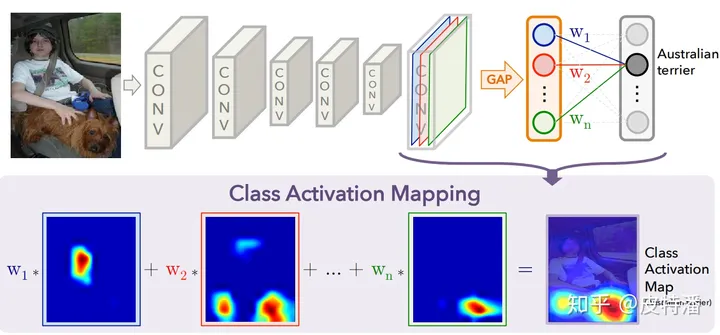

本文的做法通过上图就可以很直观理解，W1到Wn为GAP到输出层全连接到目标类别（上图目标类别为狗）的权重，由于GAP特征向量是直接来自于特征图(线性关系)，因此该权重可视为特征图对目标类别score的贡献程度，进行加权求和既可以获取CAM，公式如下:

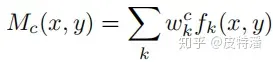

其中fk(x,y)为最后一层特征图位置(x,y)的值，Wc为类别c的全连接权重。

该方法的缺点是只能适用于最后一层特征图和全连接之间是GAP操作。 如果不是，就需要用户修改网络并重新训练(或 fine-tune)。所以对本文简单概括即为：修改网络全连接为GAP形式，利用GAP层与全连接的权重作为特征融合权重，对特征图进行线性融合获取CAM。

核心代码解读:

代码非常简单， 提取到特征图和目标类别全连接的权重，直接加权求和，再经过relu操作去除负值，最后归一化获取CAM，具体如下:

In [ ]:
# 获取全连接层的权重
self._fc_weights = self.model._modules.get(fc_layer).weight.data
# 获取目标类别的权重作为特征权重
weights=self._fc_weights[class_idx, :]
# 这里self.hook_a为最后一层特征图的输出
batch_cams = (weights.unsqueeze(-1).unsqueeze(-1) * self.hook_a.squeeze(0)).sum(dim=0)
# relu操作,去除负值
batch_cams = F.relu(batch_cams, inplace=True)
# 归一化操作
batch_cams = self._normalize(batch_cams)

Grad-CAM  (Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization)

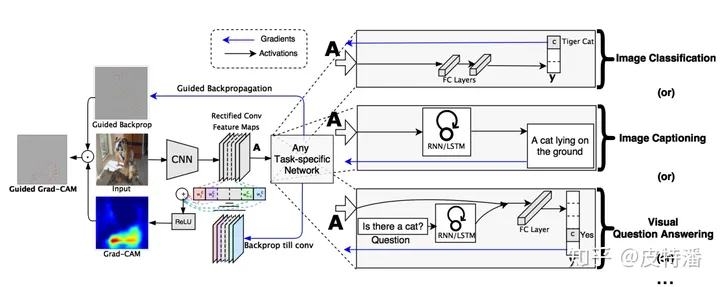

上文的局限性就是网络架构里必须有GAP层，但并不是所有模型都配GAP层的。而本文就是为克服该缺陷提出的，其基本思路是目标特征图的融合权重可以表达为梯度。另外，因为热图关心的是对分类有正面影响的特征，所以加上了relu以移除负值。其实并不一定要是分类问题，只要是可求导的激活函数，在其他问题也一样使用Grad-CAM。特征融合权重计算公式如下:

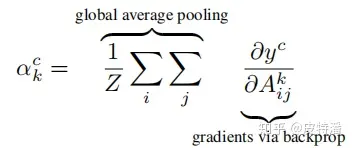

其中yc为目标类别的score。A为需要可视化的目标特征图。

A. grad-CAM和 CAM（这里指上一篇论文的做法）的区别？

1.CAM 只能用于最后一层特征图和输出之间是GAP的操作，grad-CAM可适用非GAP连接的网络结构；

2.CAM只能提取最后一层特征图的热力图，而gard-CAM可以提取任意一层；

B. 目标类别score yc是用通过softmax之后的还是之前的？

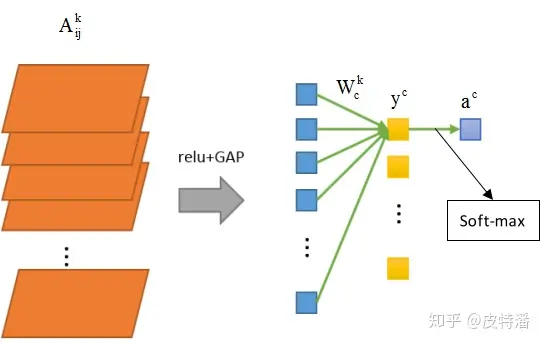

论文原文中目标类别score是指网络未经过softmax的得分，但是某些代码实现当中也使用了通过softmax后的。二者有无区别？下面我们通过公式推导一下。因为这两种做法仅仅相差一个softmax，所以对softmax的求导。假设softmax层有C个输出。

记为: 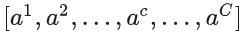，则softmax输出为：

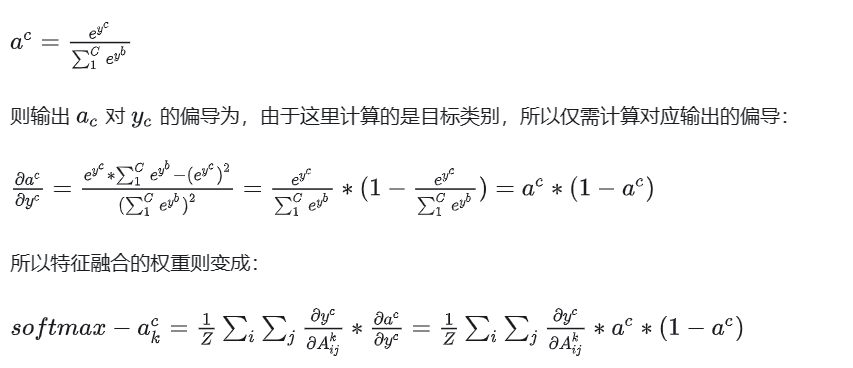

可以看出，二者的梯度差异就是softmax输出的多一项ac(1-ac)，而对于已经训练好的网络，该项为定值。后面特征层进行加权求和，再归一化后，该项会被消掉。所以通过softmax和不通过softmax在理论上完全一致。但是在实际应用中我发现，加上softmax后，权重softmax-a会变得非常小，就是因为训练的充分好的网络，预测输出ac的值是非常接近1的，所以ac(1-ac)的值非常非常小，存在丢失精度的风险。所以目标类别score建议使用不经过softmax的值。

核心代码解读:

仅需要对目标类别的score进行求导， 然后追踪到目标特征图的梯度， 对该梯队进行element-wise求平均(GAP操作)即获得特征融合的权重。具体如下:

In [ ]:
# 利用onehot的形式锁定目标类别
one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
one_hot[0][index] = 1
one_hot = torch.from_numpy(one_hot).requires_grad_(True) 
# 获取目标类别的输出,该值带有梯度链接关系,可进行求导操作
one_hot = torch.sum(one_hot * output)
self.model.zero_grad()
one_hot.backward(retain_graph=True) # backward 求导
# 获取对应特征层的梯度map
grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
target = features[-1].cpu().data.numpy()[0, :] # 获取目标特征输出
weights = np.mean(grads_val, axis=(2, 3))[0, :] # 利用GAP操作, 获取特征权重
cam = weights.dot(target.reshape((nc, h * w)))
# relu操作,去除负值, 并缩放到原图尺寸
cam = np.maximum(cam, 0)
cam = cv2.resize(cam, input.shape[2:])
# 归一化操作
batch_cams = self._normalize(batch_cams)

Grad-CAM++  (Grad-CAM++: Improved Visual Explanations for Deep Convolutional Networks)

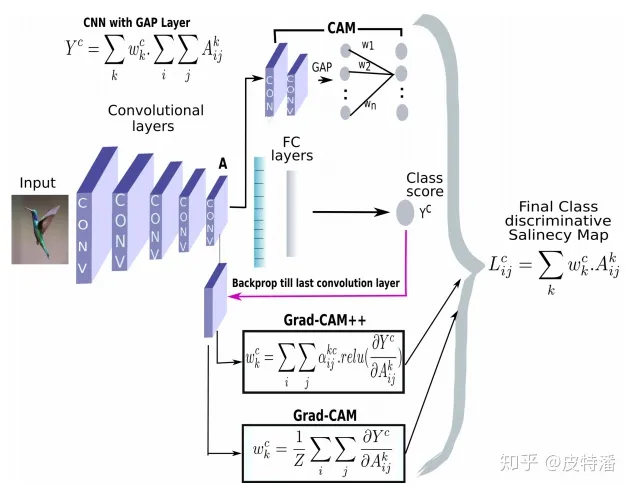

本文的提出是为了优化Grad-CAM的结果，定位会更精准，也更适用于目标类别物体在图像中不止一个的情况。 Grad-CAM是利用目标特征图的梯度求平均(GAP)获取特征图权重，可以看做梯度map上每一个元素的贡献是一样。 而本文认为梯度map上的每一个元素的贡献不同，因此增加了一个额外的权重对梯度map上的元素进行加权。其中该权重如下：

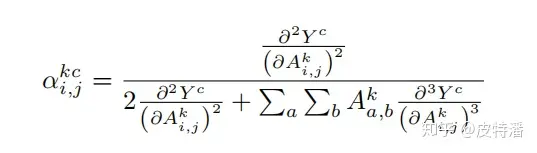

其中c为目标类别， k表示特征图第 k层(或者说第 k个channel)，i,j为该层特征图上的元素位置。可以看出公式中用到了二阶偏导和三阶偏导，计算会更复杂。

核心代码解读:

这里值得说明的是， 上面的公式有二次偏导和三次偏导，论文中进行了幂次方的转化，实现更容易。

In [ ]:
## 获取特征权重的过程
# 反向传播
self._backprop(scores, class_idx)
# 注意,这里用乘法,因为论文中将2次偏导和3次偏导进行了2次方和3次方的转化
grad_2 = self.hook_g.pow(2)
grad_3 = self.hook_g.pow(3)
# 获取alpha权重map
alpha = grad_2 / (2 * grad_2 + (grad_3 * self.hook_a).sum(axis=(2, 3), keepdims=True))
# 利用alpha 权重map去获取特征权重
return alpha.squeeze_(0).mul_(torch.relu(self.hook_g.squeeze(0))).sum(axis=(1, 2))

Smooth Grad-CAM++  (Smooth Grad-CAM++: An Enhanced Inference Level Visualization Technique for Deep Convolutional Neural Network Models)

该论文做法是结合smoothGrad来优化CAM效果，首先解释一下smoothGrad。对于分类网络，最终分类类别取决于哪个类别的score最大，公式为：

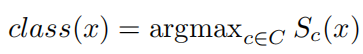

其中x为输入图片，Sc(x)为类别c的类别score。

Sc(x)对x求导，获取：

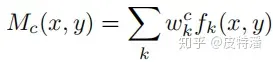

Mc表示x的每个像素的微小变化会对c类的分类score产生多大的影响，称之为saliency maps，如下图。

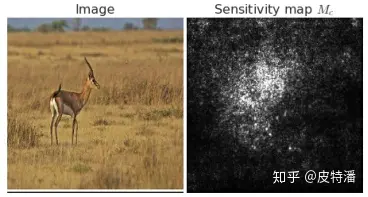

该方法虽然能显示出与分类结果相关的区域，但如图所示，存在很多噪声，且很难探究噪声的组成。smoothGrad的做法也很简单，即为多次输入加入随机噪声的图片，对结果并求平均，用以消除输出saliency maps的"噪声"，达到“引入噪声”来“消除噪声”的效果。核心公式如下:

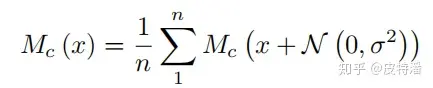

n为对原图增加噪声并前向的次数，N(0，δ2)为高斯噪声。可以看到，随着n的增加，噪声逐渐减少，saliency maps逐渐聚焦到目标物体区域。

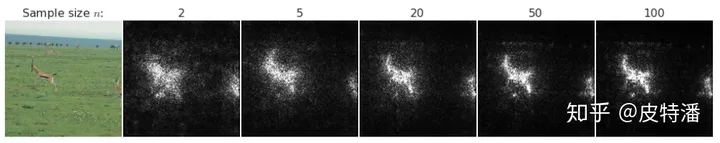

回到Smooth Grad-CAM++，如下图所示，和Grad-CAM++的区别在于特征图融合权重的求法上， 对原图多次增加高斯噪声，对目标类别对特征图的梯度求平均。

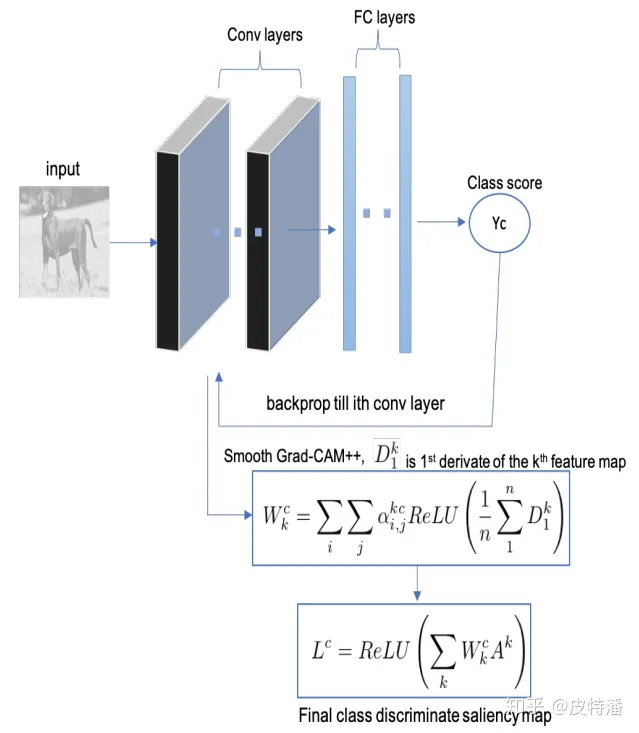

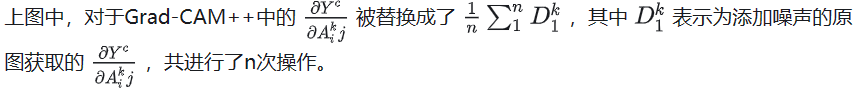

核心代码解读:

这里给的实现smoothGrad操作是作用在alpha的2次偏导和3次偏导上， 实现方式不同，本质一样。

In [ ]:
for i in range(self.n_samples): # 进行n_samples次加噪声操作
    self.model.zero_grad()
    # 输入图片增加高斯噪声
    x_with_noise = torch.normal(mean=x, std=std_tensor).requires_grad_()
    score = self.model(x_with_noise)
    score[0, idx].backward(retain_graph=True) # 求梯度
    activations = self.values.activations
    gradients = self.values.gradients
    n, c, _, _ = gradients.shape
    # 获取alpha, 和grad-cam++一致
    numerator = gradients.pow(2)
    denominator = 2 * gradients.pow(2)
    ag = activations * gradients.pow(3)
    denominator += \
    ag.view(n, c, -1).sum(-1, keepdim=True).view(n, c, 1, 1)
    denominator = torch.where(
        denominator != 0.0, denominator, torch.ones_like(denominator))
    alpha = numerator / (denominator + 1e-7)
    relu_grad = F.relu(score[0, idx].exp() * gradients)
    # 获取weights
    weights = (alpha * relu_grad).view(n, c, -1).sum(-1).view(n, c, 1, 1)
    # 对特征层加权融合, 并进行relu+归一化操作
    cam = (weights * activations).sum(1, keepdim=True)
    cam = F.relu(cam)
    cam -= torch.min(cam)
    cam /= torch.max(cam)
	total_cams += cam
total_cams /= self.n_samples # 求平均操作
return total_cams.data

gradient-free的做法： score-CAM  (Score-CAM: Score-Weighted Visual Explanations for Convolutional Neural Networks)和 ss-CAM  (SS-CAM: Smoothed Score-CAM for Sharper Visual Feature Localization)

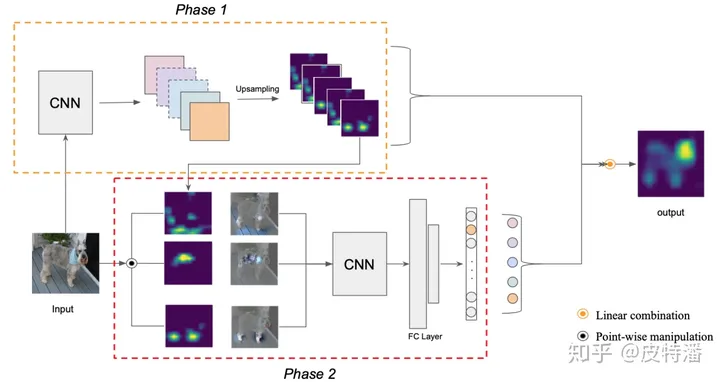

本文摒弃了利用梯度获取特征权重的做法，作者认为：

1.对于深度神经网络，梯度可能是存在噪声的，并存在饱和问题。

2.利用Grad-CAM很容易找到错误置信度的样本，既具有更高权重的激活图对网络输出的贡献较小的例子。

因此本文提出了gradient-free 的做法。首先，作者定义了CIC( (Increase of Confidence)的概念，既相对于baseline图片的置信度增量，公式如下:

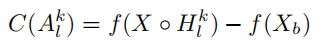

其中X为输入图片，Xb为baseline图片，可以设置为0，既全黑图片。f()为输入类别得分的神经网络，Hkl为第k层特征图， l为神经网络第l层卷积。

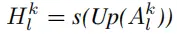

本文的做法流程为：

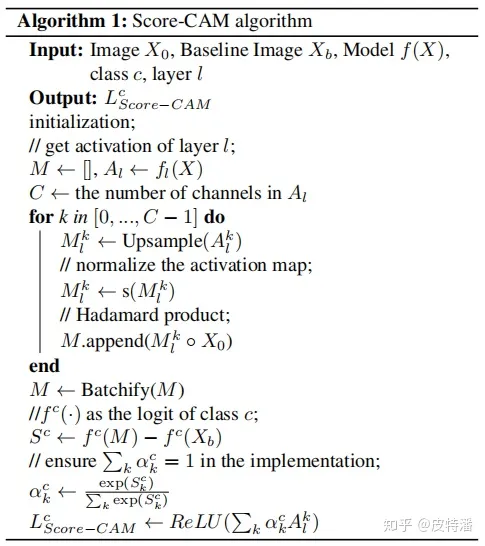

解释一下：对获取的特征图进行channel-wise遍历，对每层特征图进行上采样+归一化，与原始图片进行pixel-wise相乘融合，然后送进网络获取目标类别score（softmax后），减去baseline的目标类别score，获取CIC。再进行softmax操作来保证所有CIC之和为1。最后将CIC作为特征融合权重融合需要可视化的特征层。

核心代码解读:

值得注意的是，计算CIC时默认使用的baseline为全黑的图片，既全0的矩阵，因此CIC score不需要减去baseline的score。

In [ ]:
with torch.no_grad():# gradient-free, 所以不需要计算梯度
    for i in range(K): # 对K层特征图进行遍历操作
          # 获取第i层特征图,并进行上采样操作
          saliency_map = torch.unsqueeze(activations[:, i, :, :], 1)
          saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear')
          # 归一化
          norm_saliency_map = (saliency_map - saliency_map.min()) / 
                              (saliency_map.max() - saliency_map.min())
          # 利用第i层特征图作为mask覆盖原图,重新送入网络获取对应类别得分
          output = self.model_arch(input * norm_saliency_map)
          output = F.softmax(output)
          score = output[0][predicted_class]
          # 利用该得分作为权重对该层的特征图进行加权线性融合, baseline默认为全0的图,所以这里直接
          # 用该得分作为特征权重
          score_saliency_map +=  score * saliency_map
    # relu去除负值
    score_saliency_map = F.relu(score_saliency_map)
    # 归一化
    score_saliency_map = (score_saliency_map - score_saliency_map.min())/
                                                (score_saliency_map_max - score_saliency_map.max())
    # score_saliency_map 为所求
    return score_saliency_map

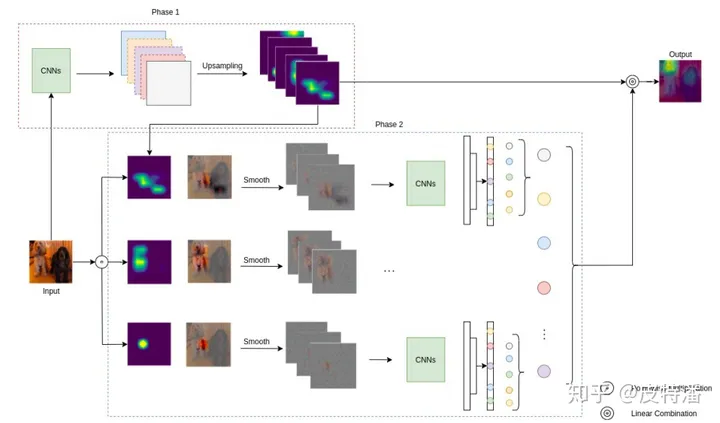

本文和score-CAM的关系类似于smooth Grad-CAM++ 和 Grad-CAM++的关系。本文同样是利用了smoothGrad技术来降低输出噪声。关于smoothGrad平滑策略， 本文给出了两种做法，一种是噪声增加在特征图上，一种是噪声增加在输入图上。这两种做法在论文给出的不同数据集上的测试指标也互有高低，具体选择也依情况而定。

利用Ablation分析的方法：Ablation-CAM  (Ablation-CAM: Visual Explanations for Deep Convolutional Network via Gradient-free Localization)

本文利用ablation分析来确定特征图上每个单元的重要程度。Ablation Study 可以理解为通过控制变量地进行移除各种组件等来探究各个因素对于模型整体贡献的强弱多寡，找到对性能最主要的影响因素。

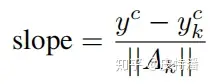

k为特征图的channel个数，这里的yc是原始图片c类别的类别score输出，ykc为将特征图第k个channel全部设置为0后，将原始图片再送进网络，获取的c类别的score。二者得分的之差，再除以||Ak||就获取slope，其实就是特征融合的权重。

由于计算||Ak||是个比较耗时的操作，于是有下面的简化形式:

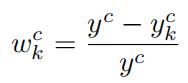

然后和Grad-CAM一致，对特征图利用该权重进行融合+relu去负值，如下:

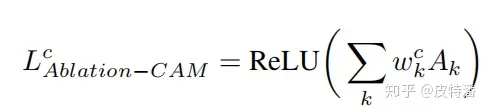

一句话概括就是遍历地将每层特征图置0后再进行网络前向获取目标类别得分, 该值与原始得分的相对大小作为特征图融合权重。论文实验表明, 该方法是优于grad-CAM的。

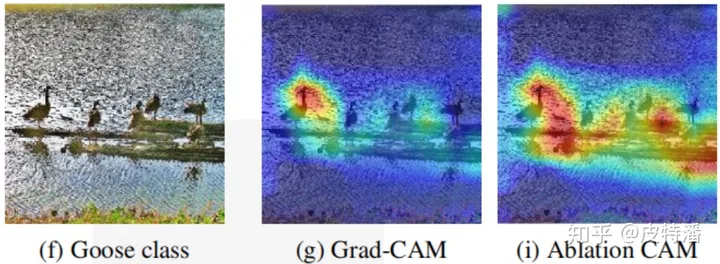